In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import random
import collections
import copy
import pickle
import itertools
from statistics import mean
import time

***
### TRANSFORMER ENCODER-DECODER IMPLEMENTATION FROM SCRATCH ON THE MACHINE TRANSLATION PROBLEM

***
### *NOTEBOOK STATE VARIABLES*

In [2]:
data_augmentation = True;
prod_mode = False;
dev_mode = True;
hyperparameters_optimization_mode = False;
inference_mode = False;
google_colab_env = False;
load_parameters = False;
load_datasets = False;
save_params = False;
en_to_fr = True;
load_on_cpu = True;
transfer_learning=False;

***
#### *GOOGLE COLAB*

CONNECT TO GOOGLE DRIVE

In [319]:
# if google_colab_env == True:
#     from google.colab import drive
#     drive.mount('/content/drive')

PRINT GPU SPECS

In [320]:
# if google_colab_env == True:
#     gpu_info = !nvidia-smi
#     gpu_info = '\n'.join(gpu_info)
#     if gpu_info.find('failed') >= 0:
#         print('Not connected to a GPU')
#     else:
#         print(gpu_info)

PRINT MEMORY SPECS

In [321]:
# if google_colab_env == True:
#     from psutil import virtual_memory
#     ram_gb = virtual_memory().total / 1e9
#     print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

#     if ram_gb < 20:
#         print('Not using a high-RAM runtime')
#     else:
#         print('You are using a high-RAM runtime!')

***
### *DATA*

Source : http://www.manythings.org/anki/

In the file **"en_fra.txt"** each line is an example and can be broken down as follows:

ENGLISH_PART \t FRENCH_PART \t REFERENCES_PART

In [3]:
with open("../data/en_fra.txt") as f:
    examples = f.readlines();

In [4]:
examples[0]

'Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)\n'

In [5]:
#The standardizeString function takes as input a string: string and a boolean: is_string_target. The algorithm applied to the string consists in:

#1. replacing in the input each unicode space character (named space_characters below) with a space " ". 
#(running example, input: "I\xa0take\xa0my\xa0coffee\xa0at\xa08:30\xa0in\xa0the\xa0   morning", output: "I take my coffee at 8:30 in the    morning")

#2. divide the string into sub-strings relative to each space (if a sub-string contains only space, it is not retained)
#(running example, input: "I take my coffee at 8:30 in the    morning", output: ["I", "take", "my", "coffee", "at" , "8:30", "in", "the", "morning"])

#3. each of the sub-strings from the previous step is passed to the _standardizeString function. The algorithm applied to each sub-string consists in isolating each special character or number 
#(named special_characters and numbers respectively below) from the other characters surrounding it. This is to maximize the generalization capacity of the translation algorithm.
#Moreover, each string is lower-cased (this ensures that no redundancy is present in the vocabulary and makes it easier to communicate with it)
#(running example, if input is "I", output is ["i"]; if input is "take", output is ["take"]; if input is "8:30", output is ["8",":", "3", "0"])

#4. the standardizeString function concatenates the outputs of _standardizeString by separating them with the token "<space>".
#(running example, ["i", "<space>", "take", "<space>", "my", "<space>", "coffee", "<space>", "at" ,"<space>", "8", ":", "3", "0", "<space>", "in", "<space>", "the", "<space>", "morning"]

#5. the token "<eos>" (meaning "end of sequence") is added to the end of the list in step 4.

#6. if the initial input of the standardizeString function is a target example (this must be set to True in the input is_string_target),
#and in this case, the token "<bos>" (meaning "begin of sequence") is added to the beginning of the list in step 5.

# IN SHORT:
# standardizeString("I\xa0take\xa0my\xa0coffee\xa0at\xa08:30\xa0in\xa0the\xa0   morning", False)
# return ['i', '<space>', 'take', '<space>', 'my', '<space>', 'coffee', '<space>', 'at', '<space>', '8', ':', '3', '0', '<space>', 'in', '<space>', 'the', '<space>', 'morning', '<eos>'];


def standardizeString(string, is_string_target):

    def _standardizeString(string):
        special_characters = '«»&~"#\'{([-|`_\\^@)]=}+¨£$¤%µ,?;.:!§*<>';
        numbers = '0123456789';

        len_string, _string = len(string), '';
        for i, char in enumerate(string):
            
            ## Handle special characters and numbers
            if char in special_characters or char in numbers:
                left_space, right_space = '', '';
                
                if i > 0 and string[i-1] != ' ':
                    left_space = ' ';

                if i+1 < len_string and string[i+1] != ' ' and string[i+1] not in special_characters and string[i+1] not in numbers:
                    right_space = ' ';
                
                _string += left_space + char + right_space;

            else:
                _string += char;

        return _string.lower().split(' ');

    ## Remove space characters
    space_characters = ['\u202f', '\u2009','\xa0'];
    for i in range(len(space_characters)):
        if space_characters[i] in string:
            string = string.replace(space_characters[i], ' ');

    _string = [s.strip() for s in string.split(' ') if s.strip() != ''];

    output = [];
    for i, _str in enumerate(_string):
        output += _standardizeString(_str);
        if i+1 < len(_string):
            output += ['<space>'];

    if is_string_target:
        output = ['<bos>'] + output;

    return output + ['<eos>'];        

In [6]:
def standardizeExamples(examples):

    en_examples, fr_examples = [], [];

    for i in range(len(examples)):
        exi = examples[i][0:examples[i].find('CC-BY 2.0')];

        exi = exi.split('\t');

        if en_to_fr:
            en_examples.append(standardizeString(exi[0], False));
            fr_examples.append(standardizeString(exi[1], True));
        else:
            en_examples.append(standardizeString(exi[0], True));
            fr_examples.append(standardizeString(exi[1], False));

    return en_examples, fr_examples;

In [7]:
if load_datasets == False:
    en_examples, fr_examples = standardizeExamples(examples);

In [8]:
if load_datasets == False:
    print(examples[87620][0:examples[87620].find('CC-BY 2.0')]);
    print('--------');
    print('EN => ',en_examples[87620]);
    print('FR => ',fr_examples[87620]);

I've got a meeting at 2:30.	J'ai une réunion à 2h30.	
--------
EN =>  ['i', "'", 've', '<space>', 'got', '<space>', 'a', '<space>', 'meeting', '<space>', 'at', '<space>', '2', ':', '3', '0', '.', '<eos>']
FR =>  ['<bos>', 'j', "'", 'ai', '<space>', 'une', '<space>', 'réunion', '<space>', 'à', '<space>', '2', 'h', '3', '0', '.', '<eos>']


In [9]:
if load_datasets == False:
    print(examples[91613][0:examples[91613].find('CC-BY 2.0')]);
    print('--------');
    print('EN => ',en_examples[91613]);
    print('FR => ',fr_examples[91613]);

"More coffee?" "No, thanks."	«Davantage de café ?» «Non, c'est bon.»	
--------
EN =>  ['"', 'more', '<space>', 'coffee', '?', '"', '<space>', '"', 'no', ',', '<space>', 'thanks', '.', '"', '<eos>']
FR =>  ['<bos>', '«', 'davantage', '<space>', 'de', '<space>', 'café', '<space>', '?', '»', '<space>', '«', 'non', ',', '<space>', 'c', "'", 'est', '<space>', 'bon', '.', '»', '<eos>']


***
### *DATA AUGMENTATION*

As explained here https://blog.tatoeba.org/2019/08/should-we-stop-sentences-with-tom-and.html?m=1, and as can be observed directly by browsing the dataset, the first name Tom and the first name Mary are the predominantly used names, and I will use this as an entry point for data augmentation. 

In [10]:
names_dataset = pd.read_csv("../data/babynames-clean.csv");
names_dataset.head()

,John,boy
0,William,boy
1,James,boy
2,Charles,boy
3,George,boy
4,Frank,boy


In [11]:
boy_names = names_dataset[names_dataset.iloc[:,1] == "boy"].reset_index().iloc[:,1];
len_boy_names = len(boy_names);
len_boy_names

3436

In [12]:
girl_names = names_dataset[names_dataset.iloc[:,1] == "girl"].reset_index().iloc[:,1];
len_girl_names = len(girl_names);
len_girl_names

3345

In [13]:
#The purpose of specialEntries and dataAugment is to increase the dataset in order to maximize the generalization capability.
#Chronologically, specialEntries did not exist and dataAugment was only intended to find examples such that the source and target examples 
#contain the same first name (e.g. "tom") and replace these first names with a first name from the babynames-clean.csv dataset.
#The addition of specialEntries does not change this, its role is simply to further increase the dataset and also (I suppose) to bring regularization at the same time
#in order to maximize the generalization capacity of the algorithm. 
#To do this, the idea behind specialEntries is always to look for examples such that the source example and the target example contain the same word 
#(not necessarily a first name, see below en_fr_identical_words), and to replace this word by:

# - if the index i of the example is a multiple of ukn_period, we replace this word by the token: "<ukn>"
# - if the index i of the example is a multiple of token_noize_period, we replace this word with: "<special_begin>", "s1", "s2", ..., "sM", "<special_end>" 
#   (M is the length of the word, and sk is the replacement of the kth character of the word by a randomly selected symbol from the list symbols - see below)
# - otherwise we replace this word with: "<special_begin>", "c1", "c2", ..., "cM", "<special_end>"
#   (such that ck is the kth character of the word)

#The token "<ukn>" has primarily a regularization purpose.
#"<special_begin>", ... , "<special_end>" (which replaces the three small dots depends on the index i) has the objective to make the algorithm able
#to process any type of input that may contain tokens not referenced by the vocabulary, I also suppose that the practice has a certain regularizing virtue. 
#Here is a practical case to illustrate:

#If for example the input is "Starladata is a new planet.", my goal was to be able to give as output "Starladata est une nouvelle planète". 
#To do this my algorithm breaks the input in the following way: 
#["<special_begin>", "s", "t", "a", "r", "l", "a", "d", "a", "t", "a", "<special_end>", "<space>", "is", "<space>", "a", "<space>", "new", "<space>", "planet", "<eos>"].

#The expected output is then as follows:
#["<bos>", "<special_begin>", "s", "t", "a", "r", "l", "a", "d", "a", "t", "a", "<special_end>", "<space>", "est", "<space>", "une", "<space>", "nouvelle", "<space>", "planète", "<eos>"].


def specialEntries(i, token_noize_period, ukn_period, word_entry_point, word_replacement, symbols):
    eni_augmented, fri_augmented = [], [];

    if i % token_noize_period == 0:
        tokens_noize = [];
        if word_replacement == None:
            for _ in range(len(word_entry_point)):
                tokens_noize.append(random.choice(symbols));
        else:
            for _ in range(len(word_replacement)):
                tokens_noize.append(random.choice(symbols));
    
    for t in en_examples[i]:
        if t == word_entry_point:
            if i % ukn_period == 0:
                eni_augmented.append('<ukn>');        
            else:
                eni_augmented.append('<special_begin>');
                if i % token_noize_period == 0:
                    for tn in tokens_noize:
                        eni_augmented.append(tn);
                else:
                    for token in word_replacement:
                        eni_augmented.append(token);
                eni_augmented.append('<special_end>');
        else:
            eni_augmented.append(t);
    en_examples.append(eni_augmented);
        
    for t in fr_examples[i]:
        if t == word_entry_point:
            if i % ukn_period == 0:
                fri_augmented.append('<ukn>'); 
            else:
                fri_augmented.append('<special_begin>');
                if i % token_noize_period == 0:
                    for tn in tokens_noize:
                        fri_augmented.append(tn);
                else:
                    for token in word_replacement:
                        fri_augmented.append(token);
                fri_augmented.append('<special_end>');
        else:
            fri_augmented.append(t);
    fr_examples.append(fri_augmented);

In [14]:
def augmentData():

    
    counter_boy = 0;
    counter_girl = 0;
    duplicate_multiplier_boy = 2;
    duplicate_multiplier_girl = 2;

    symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    symbols += ['&', 'é', '~', '"', '#', '\'', '{', '(', '[', '-', '|', 'è', '`', '_', '\\', 'ç', '^', 'à', '@', ')', ']', '=', '°', '}', '+', '/', '*', '?', ',', ';', '.', ':', '!', '§', '¨', '%', 'ù', '$', '£', '¤', 'µ', '«', '»', '<', '>'];


    for i in range(len(en_examples)):
        eni = en_examples[i];

        if 'tom' in eni and 'tom' in fr_examples[i]:
            for j in range(duplicate_multiplier_boy):
                boy_name = boy_names.iloc[((counter_boy*duplicate_multiplier_boy)+j) % len_boy_names].lower();
                eni_augmented = [boy_name if t=='tom' else t for t in eni];
                fri_augmented = [boy_name if t=='tom' else t for t in fr_examples[i]];

                en_examples.append(eni_augmented);
                fr_examples.append(fri_augmented);
            
            counter_boy += 1;

            specialEntries(i, token_noize_period=3, ukn_period=20, word_entry_point='tom', word_replacement=boy_name ,symbols=symbols);

        if 'mary' in eni and ('mary' in fr_examples[i] or 'marie' in fr_examples[i]):
            for j in range(duplicate_multiplier_girl):
                girl_name = girl_names.iloc[((counter_girl*duplicate_multiplier_girl)+j) % len_girl_names].lower();
                eni_augmented = [girl_name if t=='mary' else t for t in eni];
                fri_augmented = [girl_name if (t=='mary'or t=='marie') else t for t in fr_examples[i]];

                en_examples.append(eni_augmented);
                fr_examples.append(fri_augmented);

            counter_girl += 1;

        if 'tom' in eni and 'mary' in eni:
            boy_name = random.choice(boy_names).lower();
            girl_name = random.choice(girl_names).lower();

            eni_augmented = [girl_name if t=='mary' else t for t in eni];
            eni_augmented = [boy_name if t=='tom' else t for t in eni_augmented];

            fri_augmented = [girl_name if (t=='mary'or t=='marie') else t for t in fr_examples[i]];
            fri_augmented = [boy_name if t=='tom' else t for t in fri_augmented];

            en_examples.append(eni_augmented);
            fr_examples.append(fri_augmented);


        en_fr_identical_words = ['paris', 'canada', 'facebook', 'boston', 'jupiter', 'pizza', 'vodka', 'piano', 'train', 'radio', 'message', 'danger'];
        duplicate_multiplier = 3;
        for word in en_fr_identical_words:
            if word in eni and word in fr_examples[i]:
                for _ in range(duplicate_multiplier):
                    specialEntries(i, token_noize_period=1, ukn_period=20, word_entry_point=word, word_replacement=None, symbols=symbols);

In [15]:
if data_augmentation is True:
    augmentData();

In [339]:
# for en, fr in zip(en_examples,fr_examples):
#     print(en)
#     print(fr)
#     print("********")

***
### *DATASET STATISTICS*

In [16]:
def sequencesLen(dataset_examples):
    
    sequences_len = [];
    
    for i in range(len(dataset_examples)):
        sequences_len.append(len(dataset_examples[i]));
        
    return torch.tensor(sequences_len);

DATASET SIZE

In [17]:
if load_datasets == False:
    print(len(en_examples))

315680


ENGLISH SEQUENCES LENGTH HISTOGRAM

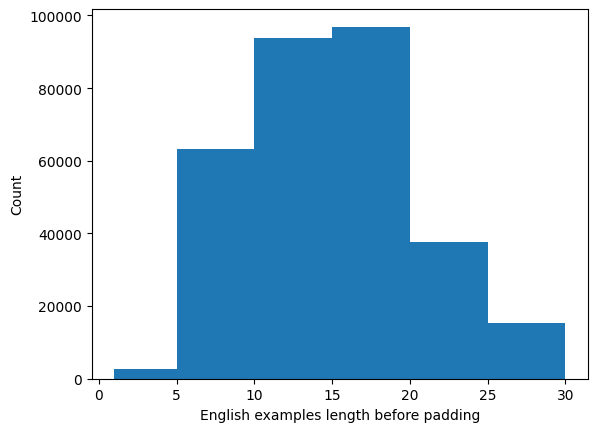

In [21]:
if load_datasets == False:
    en_examples_length = sequencesLen(en_examples);

    plt.hist(en_examples_length, [1,5,10,15,20,25,30]);
    plt.xlabel("English examples length before padding");
    plt.ylabel("Count");

FRENCH SEQUENCES LENGTH HISTOGRAM

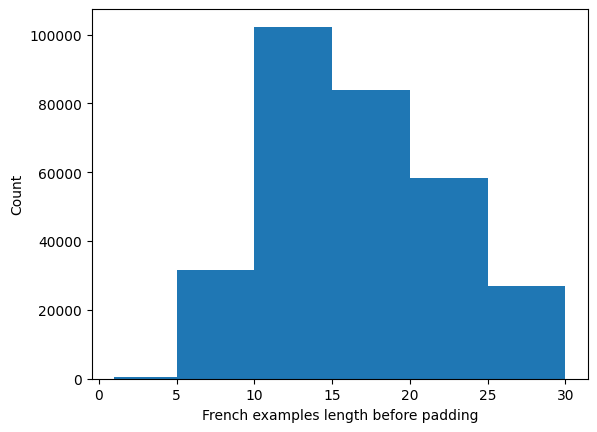

In [22]:
if load_datasets == False:
    fr_examples_length = sequencesLen(fr_examples);

    plt.hist(fr_examples_length, [1,5,10,15,20,25,30]);
    plt.xlabel("French examples length before padding");
    plt.ylabel("Count");

Note: These statistics inform me on the ideal groups (see datasets(...) below) for training efficiency. 
(i.e. avoiding that a short sequence is padded against the longest sequence in the dataset. First, this unnecessarily increases training resources and second, it hurts the signal-to-noise ratio.);

***
### *VOCAB*

In [344]:
class Vocab:
    def __init__(self, dataset2d):
        self.token_to_idx = {};
        self.idx_to_token = [];
        self.initVocab(dataset2d);
        
    def initVocab(self, dataset2d):
        token_freq = collections.Counter(
            [dataset2d[i][j] for i in range(len(dataset2d)) for j in range(len(dataset2d[i]))]);
        token_freq = token_freq.most_common();
  
        for i in range(len(token_freq)):
            self.token_to_idx[token_freq[i][0]] = i;
            self.idx_to_token.append(token_freq[i][0]);
             
    def tokenToIdx(self, dataset2d):
        for i in range(len(dataset2d)):
            dataset2d_irow = [];
            for j in range(len(dataset2d[i])):
                current_token = dataset2d[i][j];

                if current_token not in self.idx_to_token:
                    dataset2d_irow.append(self.token_to_idx['<special_begin>'])
                    for token in current_token:
                        if token not in self.idx_to_token:
                            dataset2d_irow.append(self.token_to_idx['<ukn>']);
                        else:
                            dataset2d_irow.append(self.token_to_idx[token]);
                    dataset2d_irow.append(self.token_to_idx['<special_end>'])
                else:
                    dataset2d_irow.append(self.token_to_idx[current_token]);

            dataset2d[i] = dataset2d_irow;
                    
        return torch.tensor(dataset2d);

    def idxToToken(self, dataset2d):
        dataset2d = dataset2d.tolist();
        
        for i in range(len(dataset2d)):
            for j in range(len(dataset2d[i])):
                dataset2d[i][j] = self.idx_to_token[dataset2d[i][j]];
        return dataset2d;

    def expandVocab(self, dataset2d):
        token_freq = collections.Counter(
            [dataset2d[i][j] for i in range(len(dataset2d)) for j in range(len(dataset2d[i]))]);
        token_freq = token_freq.most_common();
  
        for i in range(len(token_freq)):
            if token_freq[i][0] not in self.idx_to_token:
                self.token_to_idx[token_freq[i][0]] = len(self.idx_to_token);
                self.idx_to_token.append(token_freq[i][0]);
    
    def __len__(self):
        return len(self.idx_to_token);

***
### *DATASETS TRAIN/TEST AND THEIR RESPECTIVE VOCABULARY*

In [345]:
def dataLoader(batch_size, shuffle, *tensors):
    TD = torch.utils.data.TensorDataset(*tensors);
    return torch.utils.data.DataLoader(TD, batch_size, shuffle);

In [346]:
## Determine the longest sequence among dataset_examples 
## and complete the other sequences with the <pad> token so that their length matches the longest.

def padding(dataset_examples):
    
    max_length = 0;

    def maxLength(dataset, max_length):
        for i in range(len(dataset)):
            if len(dataset[i]) > max_length:
                max_length = len(dataset[i]);
        return max_length;
                
    max_length = maxLength(dataset_examples, max_length);
    
    def pad(dataset, max_length):
        for i in range(len(dataset)):
            if len(dataset[i]) < max_length:
                dataset[i] += ['<pad>']*(max_length-len(dataset[i]));
        return dataset;
    
    dataset_examples = pad(dataset_examples, max_length);
                
    return dataset_examples;

In [347]:
# def datasets(source_examples, target_examples, dataset_train_size, dataset_test_size, 
#              batch_size_train, batch_size_test):
    
#     source_examples = copy.deepcopy(source_examples);
#     target_examples = copy.deepcopy(target_examples);
    
#     ## The document "en_fra.txt" provides examples in ascending order of the number of tokens.
#     ## So before delineating my training/test datasets, randomize the order of the examples,
#     ## in order to maximize the heterogeneity in both.
#     random_indexation = torch.randperm(dataset_train_size + dataset_test_size);
    
#     source_examples = source_examples[0:dataset_train_size+dataset_test_size];
#     source_examples = [source_examples[random_indexation[i]] for i in range(len(random_indexation))];
#     target_examples = target_examples[0:dataset_train_size+dataset_test_size];
#     target_examples = [target_examples[random_indexation[i]] for i in range(len(random_indexation))];

#     ## source_seq_len[i] = the number of tokens of sequence i (before padding).
#     ## The importance of these quantities lies in the calculation of the context variable C in the encoder.
#     source_seq_len = sequencesLen(source_examples);
#     source_seq_len_train = source_seq_len[0:dataset_train_size];
#     source_seq_len_test = source_seq_len[dataset_train_size:dataset_train_size+dataset_test_size];
    
#     source_examples = padding(source_examples);
#     target_examples = padding(target_examples);

#     source_vocab = Vocab(source_examples);
#     source_examples = source_vocab.tokenToIdx(source_examples);
#     target_vocab = Vocab(target_examples);
#     target_examples = target_vocab.tokenToIdx(target_examples);

#     ds_src_train = source_examples[0:dataset_train_size];
#     ds_trg_train_in = target_examples[0:dataset_train_size][:,:-1];
#     ds_trg_train_out = target_examples[0:dataset_train_size][:,1:];
#     datasets_train = dataLoader(batch_size_train, True, ds_src_train, source_seq_len_train, 
#                                 ds_trg_train_in, ds_trg_train_out); 
    
#     ds_src_test = source_examples[dataset_train_size:dataset_train_size+dataset_test_size];
#     ds_trg_test_out = target_examples[dataset_train_size:dataset_train_size+dataset_test_size][:,1:];
#     datasets_test = dataLoader(batch_size_test, False, ds_src_test, source_seq_len_test, ds_trg_test_out);
    
#     return datasets_train, datasets_test, source_vocab, target_vocab;

In [348]:
# dataset_train_size = 500;
# dataset_test_size = 10;
# batch_size_train = 500;
# batch_size_test = 10;

# datasets_train, datasets_test, source_vocab, target_vocab = datasets(en_examples, 
#                                                                      fr_examples, 
#                                                                      dataset_train_size, 
#                                                                      dataset_test_size, 
#                                                                      batch_size_train, 
#                                                                      batch_size_test);


In [349]:
# groups is a list of int, it is the list that determines the different dataset groups according to the sequences length;
# e.g. if groups = [5,10,15,20,25] then the following groups will be made:
# (0,5], (5,10], (10, 15], (15, 20], (20, 25].
#
# Assumptions: groups = [g1,g2,g3,...,gG];
# g1,g2,g3,...,gG > 0;
# g1<g2<g3<...<gG;

# The group_maker can takes the value 1 or 2 and is the parameter that determines
# from which datasets: source_examples (1) or target_examples (2) we make the groups. 

def datasets(source_examples, target_examples, groups, group_maker, batch_size_train):

    source_examples_groups, target_examples_groups = [], [];

    ## DEV # 
    ## facilitates the development of the datasets(...) function because it avoids directly modifying 
    ## the memory space of source_examples and target_examples and therefore it avoids having 
    ## to restart the whole notebook in order to reset the datasets before calling the datasets(...) function again.
    if dev_mode: 
        source_examples = copy.deepcopy(source_examples);
        target_examples = copy.deepcopy(target_examples);

    # CHECKS GROUPS ASSUMPTIONS
    if min(groups) < 0:
        raise ValueError("groups elements must be positive");
    groups.sort();

    if group_maker == 1:
        examples_len = sequencesLen(source_examples);
    else:
        examples_len = sequencesLen(target_examples);

    # CREATE GROUPS
    for i in range(len(groups)):
        group_lower_bound = 0 if i == 0 else groups[i-1];
        group_upper_bound = groups[i];

        lower_bound_true = group_lower_bound < examples_len;
        upper_bound_true = examples_len <= group_upper_bound;

        lower_upper_bound_true_indices = (lower_bound_true & upper_bound_true).nonzero(as_tuple=True)[0];

        source_examples_group = list(source_examples[i] for i in lower_upper_bound_true_indices);
        target_examples_group = list(target_examples[i] for i in lower_upper_bound_true_indices);

        source_examples_groups.append(source_examples_group);
        target_examples_groups.append(target_examples_group);

    number_groups = len(source_examples_groups);


    # SOURCE SEQUENCES LENGTH
    source_seq_len = [];
    for i in range(number_groups):
        source_seq_len.append(sequencesLen(source_examples_groups[i]));

    # PADDING 
    for i in range(number_groups):
        source_examples_groups[i] = padding(source_examples_groups[i]);
        target_examples_groups[i] = padding(target_examples_groups[i]);


    # CREATE VOCAB
    for i in range(number_groups):
        if i == 0:
            source_vocab = Vocab(source_examples_groups[i])
            target_vocab = Vocab(target_examples_groups[i]);
        else:
            source_vocab.expandVocab(source_examples_groups[i]);
            target_vocab.expandVocab(target_examples_groups[i]);

    # TOKEN TO INDEX
    for i in range(number_groups):
        source_examples_groups[i] = source_vocab.tokenToIdx(source_examples_groups[i]);
        target_examples_groups[i] = target_vocab.tokenToIdx(target_examples_groups[i]);

    
    # TRAIN DATASETS
    datasets_train = [];

    for i in range(number_groups):
        if len(source_examples_groups[i]) == 0:
            continue;

        src_train = source_examples_groups[i];
        src_seq_len_train = source_seq_len[i];

        trg_train_in = target_examples_groups[i][:,:-1];
        trg_train_out = target_examples_groups[i][:,1:];

        datasets_train.append(dataLoader(batch_size_train, True, src_train, src_seq_len_train, trg_train_in, trg_train_out));

    
    return datasets_train, source_vocab, target_vocab;

In [350]:
if en_to_fr:
    if dev_mode:
        # datasets_train, source_vocab, target_vocab = datasets(en_examples[0:250], fr_examples[0:250], [5,10,15,20,25], 1, 250);
        datasets_train, source_vocab, target_vocab = datasets(en_examples, fr_examples, [5,10,15,20,25], 1, 250);


    if prod_mode or hyperparameters_optimization_mode or inference_mode:
        if load_datasets:
            with open("../saved_objects/datasets_object_enfr.pkl", 'rb') as f:
                datasets_train, source_vocab, target_vocab = pickle.load(f);
            
        else:
            datasets_train, source_vocab, target_vocab = datasets(en_examples, fr_examples, [5,10,15,20,25], 1, 1024);
            with open("../saved_objects/datasets_object_enfr.pkl", 'wb') as f:
                pickle.dump((datasets_train, source_vocab, target_vocab), f, pickle.HIGHEST_PROTOCOL);


else:
    if dev_mode:
        datasets_train, source_vocab, target_vocab = datasets(fr_examples[0:250], en_examples[0:250], [5,10,15,20,25], 1, 250);

    if prod_mode or hyperparameters_optimization_mode or inference_mode:
        if load_datasets:
            with open("../saved_objects/datasets_object_fren.pkl", 'rb') as f:
                datasets_train, source_vocab, target_vocab = pickle.load(f);
            
        else:
            datasets_train, source_vocab, target_vocab = datasets(fr_examples, en_examples, [5,10,15,20,25], 1, 1024);
            with open("../saved_objects/datasets_object_fren.pkl", 'wb') as f:
                pickle.dump((datasets_train, source_vocab, target_vocab), f, pickle.HIGHEST_PROTOCOL);

In [351]:
len(source_vocab), len(target_vocab)

(21019, 31544)

Dump source_vocab and target_vocab in a pickle file in order to use them in production

In [352]:
if load_datasets == False:
    if en_to_fr:
        with open("../saved_objects/vocabs_en_to_fr.pkl", 'wb') as f:
            pickle.dump(source_vocab, f, pickle.HIGHEST_PROTOCOL);
            pickle.dump(target_vocab, f, pickle.HIGHEST_PROTOCOL);
    else:
        with open("../saved_objects/vocabs_fr_to_en.pkl", 'wb') as f:
            pickle.dump(source_vocab, f, pickle.HIGHEST_PROTOCOL);
            pickle.dump(target_vocab, f, pickle.HIGHEST_PROTOCOL);

***
### *COMPUTATIONAL DEVICE*

In [353]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');

print("DEVICE : ", device);

DEVICE :  cpu


***
### *ATTENTION*

***
Note: The implementation of Multi-Head Attention below follows the implementation of the paper "Attention Is All You Need" while the schema in the notebook [MultiHeadAttention_ch11](https://github.com/Excelsior7/DIVEINTODEEPLEARNING/blob/main/Attention_mechanisms/MultiHeadAttention_ch11.md) follows the implementation of the book "Dive Into Deep Learning".

*In the first case* : 
Queries, Keys and Values are multiplied by a weight matrix WQi, WKi, WVi, respectively in the case of the ith head. (See image below for more details)

*In the second case*:
Queries, Keys and Values are multiplied by a weight matrix WQ, WK, WV, respectively. Following this transformation, Queries, Keys and Values will each be split into several parts (the same number of parts: **num_heads**), along the last dimension (dim=-1). The ith part of Queries, the ith part of Keys and the ith part of Values will form the ith head
(see [MultiHeadAttention_ch11](https://github.com/Excelsior7/DIVEINTODEEPLEARNING/blob/main/Attention_mechanisms/MultiHeadAttention_ch11.md))
***

![png](../../../plots/Transformer_fig1.png) 

"Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this." - page 5.

source : https://arxiv.org/abs/1706.03762?context=cs

In [354]:
def maskedSoftmax(QK, source_seq_len, mask):
    # QK.shape = (batch_size, num_steps, num_steps)
    
    QK_shape = QK.shape;
    
    if mask is True:
        mask_to_apply = ~(torch.arange(0,QK_shape[1])[None,:] < torch.arange(1,QK_shape[1]+1)[:,None]);
        mask_to_apply = mask_to_apply.unsqueeze(dim=0).repeat(QK_shape[0],1,1);
        
        QK[mask_to_apply] = -1e6;
    
    if source_seq_len is not None:
        steps = torch.arange(1, QK_shape[1]+1).unsqueeze(dim=0).repeat(QK_shape[1],1).unsqueeze(dim=0).repeat(QK_shape[0], 1, 1).to(device);
        valid_len = source_seq_len.unsqueeze(dim=1).unsqueeze(dim=1).repeat_interleave(repeats=QK_shape[1], dim=1);
        padding_mask = steps > valid_len;
        
        QK[padding_mask] = -1e6;
    
    return nn.functional.softmax(QK, dim=-1);

In [355]:
def scaledDotProductAttention(Q, K, V, dk, source_seq_len, mask):
    QK = torch.bmm(Q,K.transpose(1,2)) / math.sqrt(dk);
    
    return torch.bmm(maskedSoftmax(QK, source_seq_len, mask), V);

In [356]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, dk, dv, dmodel):
        super().__init__();
        
        self.num_heads = num_heads;
        self.dk = dk;
        
        self.weights_params = nn.ModuleList();
        for i in range(num_heads):
            WQi = nn.Linear(dmodel,dk);
            WKi = nn.Linear(dmodel,dk);
            WVi = nn.Linear(dmodel,dv);

            weights = nn.ModuleList([WQi,WKi,WVi]);
            self.weights_params.append(weights);
            
        self.WO = nn.Linear(num_heads*dv,dmodel);
    
    def forward(self, queries, keys, values, source_seq_len=None, mask=False):
        # (queries|keys|values).shape = (batch_size, num_steps, dmodel)
        
        heads = [];
        
        for i in range(self.num_heads):
            WQi, WKi, WVi = self.weights_params[i];
            
            # ith head shape = (batch_size, num_steps, dv)
            heads.append(
                scaledDotProductAttention(WQi(queries), WKi(keys), WVi(values), self.dk, source_seq_len, mask));
        
        # heads.shape = (batch_size, num_steps, num_heads*dv)
        heads = torch.cat(heads, dim=-1);
        
        return self.WO(heads);

***
### *POSITION-WISE FEED FORWARD NETWORKS*

In [357]:
class FFN(nn.Module):
    def __init__(self, dmodel, dff):
        super().__init__();
        
        self.W1 = nn.Linear(dmodel,dff);
        self.W2 = nn.Linear(dff,dmodel);
        self.relu = nn.ReLU();
        
    def forward(self, X):
        # X.shape = (batch_size, num_steps, dmodel)
        
        return self.W2(self.relu(self.W1(X)));

***
### *RESIDUALS*

"And so what has happened was these residuals were carrying position information to every layer." - Ashish Vaswani

source : https://www.youtube.com/watch?v=5vcj8kSwBCY&t=1110s [Importance of Residuals (19:30 - 20:45)]

In [358]:
class AddandNorm(nn.Module):
    def __init__(self, dmodel, dropout=0):
        super().__init__();
        
        self.LN = nn.LayerNorm(dmodel);
        self.dropout = nn.Dropout(dropout);
    
    def forward(self, X, Y):
        # (X|Y).shape = (batch_size, num_steps, dmodel)

        return self.LN(X + self.dropout(Y));

***
### *POSITIONAL ENCODING*

![png](../../../plots/Transformer_fig2.png)

source : https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

In [359]:
class PositionalEncoding(nn.Module):
    def __init__(self, dmodel, dropout, max_seq_len=1000):
        super().__init__();
        
        # It is possible that dmodel is odd but this makes the code more complex without adding value.
        assert dmodel % 2 == 0, "dmodel must be even";
        
        self.dropout = nn.Dropout(dropout);
        
        # t.shape = (max_seq_len, dmodel/2)
        t = torch.arange(0,max_seq_len).unsqueeze(dim=1).repeat_interleave(repeats=int(dmodel/2),dim=1);
        # w.shape = (max_seq_len, dmodel/2)
        wk = 1/torch.pow(10000, torch.arange(0,dmodel,step=2)/dmodel).unsqueeze(dim=0);
        wk = wk.repeat_interleave(repeats=max_seq_len,dim=0);
        
        # pos_encoding.shape = (max_seq_len, dmodel)
        self.pos_encoding = torch.zeros(max_seq_len, dmodel);
        self.pos_encoding[:,0::2] = torch.sin(wk*t);
        self.pos_encoding[:,1::2] = torch.cos(wk*t);

        self.pos_encoding = self.pos_encoding.to(device);

    def forward(self, X):
        # X.shape = (batch_size, num_steps, dmodel)
        X_shape = X.shape;
        
        pos_encoding = self.pos_encoding[:X_shape[1],:].unsqueeze(dim=0).repeat(X.shape[0],1,1);
        
        return self.dropout(pos_encoding + X);

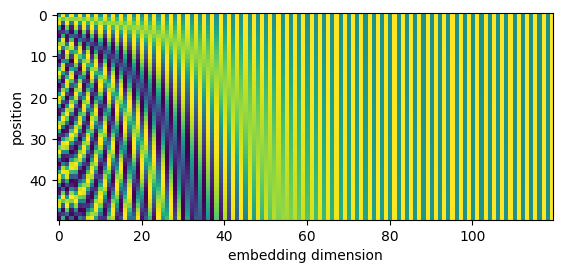

In [360]:
pe = PositionalEncoding(dmodel=120,dropout=0,max_seq_len=50).pos_encoding;
plt.imshow(pe.cpu());
plt.xlabel("embedding dimension");
plt.ylabel("position");
plt.show();

***
### *ENCODER-DECODER MODEL*

Note: 
In the "def datasets" function, I call the "def padding" function for sources_examples and target_examples independently, and what results is that "num_steps" can vary in src_X (built on sources_examples) versus bos_X (built on target_examples).

**ENCODER**

In [361]:
class EncoderBlock(nn.Module):
    def __init__(self, num_heads, dmodel, dk, dv, dff, dropout):
        super().__init__();
        
        self.MHA = MultiHeadAttention(num_heads, dk, dv, dmodel);
        self.AAN = AddandNorm(dmodel, dropout);
        self.FFN = FFN(dmodel, dff);

    def forward(self, X, source_seq_len):
        # sli_out.shape = (batch_size, number of steps in src_X, dmodel)
        # sli stands for the ith sublayer of the encoder block.
        
        sl1_out = self.MHA(X, X, X, source_seq_len);
        sl1_out = self.AAN(X, sl1_out);
        
        sl2_out = self.FFN(sl1_out)
        sl2_out = self.AAN(sl1_out, sl2_out);
        
        return sl2_out;

In [362]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, num_blocks, num_heads, dmodel, dk, dv, dff, dropout, max_seq_len=1000):
        super().__init__();
        
        self.num_blocks = num_blocks;
        self.embedding = nn.Embedding(vocab_size, dmodel);
        self.pencoding = PositionalEncoding(dmodel, dropout, max_seq_len);
        
        self.encoder_blocks = nn.ModuleList();
        for _ in range(num_blocks):
            self.encoder_blocks.append(EncoderBlock(num_heads, dmodel, dk, dv, dff, dropout));

    def forward(self, src_X, source_seq_len_train):
        
        # X.shape = (batch_size, number of steps in src_X, dmodel)
        X = self.pencoding(self.embedding(src_X));

        for i in range(self.num_blocks):
            X = self.encoder_blocks[i](X, source_seq_len_train);
            
        return X;

**DECODER**

In [363]:
class DecoderBlock(nn.Module):
    def __init__(self, num_heads, dmodel, dk, dv, dff, dropout):
        super().__init__();
        
        self.MHA1 = MultiHeadAttention(num_heads, dk, dv, dmodel);
        self.MHA2 = MultiHeadAttention(num_heads, dk, dv, dmodel);
        self.AAN = AddandNorm(dmodel, dropout);
        self.FFN = FFN(dmodel, dff);
        
    def forward(self, X, enc_output, mask=False):
        # X.shape = (batch_size, number of steps in bos_X, dmodel)
        # enc_output.shape = (batch_size, number of steps in src_X, dmodel)
        
        # sli_out.shape = (batch_size, number of steps in bos_X, dmodel)
        # sli stands for the ith sublayer of the decoder block.
        
        sl1_out = self.MHA1(X, X, X, None, mask);
        sl1_out = self.AAN(X, sl1_out);
        
        sl2_out = self.MHA2(sl1_out, enc_output, enc_output);
        sl2_out = self.AAN(sl1_out, sl2_out);
        
        sl3_out = self.FFN(sl2_out);
        sl3_out = self.AAN(sl2_out, sl3_out);
        
        return sl3_out; 

In [364]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, num_blocks, num_heads, dmodel, dk, dv, dff, dropout, max_seq_len=1000):
        super().__init__();
        
        self.num_blocks = num_blocks;
        self.embedding = nn.Embedding(vocab_size, dmodel);
        self.pencoding = PositionalEncoding(dmodel, dropout, max_seq_len);
        
        self.W_out = nn.Linear(dmodel, vocab_size);
        
        self.decoder_blocks = nn.ModuleList();
        for _ in range(num_blocks):
            self.decoder_blocks.append(DecoderBlock(num_heads, dmodel, dk, dv, dff, dropout));
        
    def forward(self, bos_X, enc_output):
        
        # X.shape = (batch_size, number of steps in bos_X, dmodel)
        X = self.pencoding(self.embedding(bos_X));
        
        mask = True if self.training else False;
        
        for i in range(self.num_blocks):
            X = self.decoder_blocks[i](X, enc_output, mask);
            
        return self.W_out(X);

**ENCODER-DECODER**

In [365]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__();
        self.encoder = encoder;
        self.decoder = decoder;
        
    def forward(self, src_X, bos_X, source_seq_len):
        # src_X.shape = (batch_size, number of steps in src_X)
        # bos_X.shape = (batch_size, number of steps in bos_X)

        enc_output = self.encoder(src_X, source_seq_len);
        Y_hat = self.decoder(bos_X, enc_output);
        
        return Y_hat;

***
### *ATTENTION IS ALL YOU NEED SCHEDULER*

In [366]:
# class AIAYNScheduler():
#     def __init__(self, optimizer, dmodel, warmup_steps):
#         self._optimizer = optimizer;
#         self._dmodel = dmodel;
#         self._warmup_steps = warmup_steps;
#         self._num_steps = 0;

#     def step(self):
#         self._num_steps += 1;
#         self._updateLR();

#     def _updateLR(self):
#         dmodel = self._dmodel;
#         ws = self._warmup_steps;
#         step = self._num_steps;

#         for g in self._optimizer.param_groups:
#             g['lr'] = (dmodel ** (-0.5)) * min(step**(-0.5), step * ws**(-1.5));

***
### *MODEL INSTANTIATION AND PARAMETERS LOADING*

In [367]:
# ENCODER PARAMETERS
source_vocab_size = len(source_vocab);

# DECODER PARAMETERS
target_vocab_size = len(target_vocab);

## Attention is all you need paper hyperparameters on base model:
# num_blocks = 6;
# num_heads = 8;
# dmodel = 512;
# dk = dv = 64;
# dff = 2048;
# dropout = 0.1;

## FIRST MODEL INSTANTIATION / TRAIN ON GPU
# load_parameters = False;
# load_on_cpu = False;

## RESUME TRAINING / TRAIN ON GPU
# load_parameters = True;
# load_on_cpu = False;

## INFERENCE ON CPU
# load_parameters = True;
# load_on_cpu = True;

## Note on transfer learning : If transfer learning is desired, call the file that contains the pre-trained model transfer_weights.tar

def instantiateModel(num_blocks, num_heads, dmodel, dk, dv, dff, dropout, learning_rate, weight_decay, load_parameters=False, load_on_cpu=False, transfer_learning=False):
    if load_parameters:
        if load_on_cpu:
            if en_to_fr:
                checkpoint = torch.load('../saved_objects/parameters_Transformer_en_to_fr.tar', map_location=torch.device('cpu'));
            else:
                checkpoint = torch.load('../saved_objects/parameters_Transformer_fr_to_en.tar', map_location=torch.device('cpu'));
        else:
            if en_to_fr:
                checkpoint = torch.load('../saved_objects/parameters_Transformer_en_to_fr.tar');
            else:
                checkpoint = torch.load('../saved_objects/parameters_Transformer_fr_to_en.tar');
    
    if transfer_learning:
      if load_on_cpu:
        checkpoint = torch.load('../saved_objects/transfer_weights.tar', map_location=torch.device('cpu'));
      else:
        checkpoint = torch.load('../saved_objects/transfer_weights.tar');


    encoder = Encoder(source_vocab_size, num_blocks, num_heads, dmodel, dk, dv, dff, dropout);
    decoder = Decoder(target_vocab_size, num_blocks, num_heads, dmodel, dk, dv, dff, dropout);
    model = EncoderDecoder(encoder, decoder);
    if load_parameters or transfer_learning:
        model.load_state_dict(checkpoint['model_state_dict']);
    
    if load_on_cpu == False:
        model.to(torch.device('cuda'));

    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay, lr=learning_rate);
    if load_parameters:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict']);

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=20, verbose=True);

    return model, optimizer, scheduler;

In [368]:
if dev_mode:
  model, optimizer, scheduler = instantiateModel(2,4,128,32,32,64,0.1,0.0004,0, 
                                                load_parameters=load_parameters, 
                                                load_on_cpu=load_on_cpu, 
                                                transfer_learning=transfer_learning);

if prod_mode:
  model, optimizer, scheduler = instantiateModel(6,8,512,64,64,2048,0.1,0.0004,0.001, 
                                                load_parameters=load_parameters, 
                                                load_on_cpu=load_on_cpu, 
                                                transfer_learning=transfer_learning);

***
### *LOSS*

In [369]:
CEL = nn.CrossEntropyLoss();

In [370]:
def loss(Y_hat, Y):

    pad_idx = target_vocab.token_to_idx['<pad>'];

    Y_hat = Y_hat.reshape(-1, Y_hat.shape[-1]);
    Y = Y.flatten();
    
    is_not_pad = Y != pad_idx;
    
    Y_hat = Y_hat[is_not_pad];
    Y = Y[is_not_pad];

    return CEL(Y_hat, Y);

***
### *HYPERPARAMETERS OPTIMIZATION*

In [371]:
def hyperparametersSpace():

    HP_num_blocks = [6];
    HP_num_heads = [8];
    HP_dmodel = [512];
    HP_dk = [64];
    HP_dff = [2048];
    HP_dropout = [0.1,0.2,0.3];
    HP_learning_rate = [0.04,0.004,0.0004];
    HP_weight_decay = [0.1,0.01,0.001];

    return [HP_num_blocks, HP_num_heads, HP_dmodel, HP_dk, HP_dff, HP_dropout, HP_learning_rate, HP_weight_decay];

In [372]:
def HO(HO_datasets, hyperparameters, loss):

  num_epochs = 3;
  min_metrics_mean, min_id = 0, math.inf;

  for id, h in enumerate(itertools.product(*hyperparameters)):
    _num_blocks = h[0];
    _num_heads = h[1];
    _dmodel = h[2];
    _dk = h[3];
    _dv = h[3];
    _dff = h[4];
    _dropout = h[5];
    _learning_rate = h[6];
    _weight_decay = h[7];

    model, optimizer, _ = instantiateModel(_num_blocks,_num_heads,_dmodel,_dk,_dv,_dff,_dropout,_learning_rate,_weight_decay);
    model.to(device);
    metrics = [];

    model.train();
    for epoch in range(num_epochs):
        for dataset in HO_datasets:
            for src_X, source_seq_len_train, bos_X, Y in dataset:

              src_X = src_X.to(device);
              source_seq_len_train = source_seq_len_train.to(device);
              bos_X = bos_X.to(device);
              Y = Y.to(device);

              l = loss(model(src_X, bos_X, source_seq_len_train), Y);

              with torch.no_grad():
                  l.backward();
                  optimizer.step();
                  optimizer.zero_grad();

                  if epoch == 1:
                    metrics.append(l.item());
                    break;

    metrics_mean = mean(metrics);
    if metrics_mean < min_metrics_mean:
      min_metrics_mean = metrics_mean;
      min_id = id;

    with open("../saved_objects/hyperparameters_optimization.txt", "a") as f:
      f.write(f"min_id:{min_id}, num_blocks:{_num_blocks}, num_heads:{_num_heads}, dmodel:{_dmodel}, ");
      f.write(f"_dk:{_dk}, _dv:{_dv}, _dff:{_dff}, ");
      f.write(f"_dropout:{_dropout}, _learning_rate:{_learning_rate}, _weight_decay:{_weight_decay}.\n");
      f.write(f"metrics {metrics}.\n");
      f.write(f"metrics mean {metrics_mean}.\n");
      f.write("*************************************\n");
      f.close();

In [373]:
if hyperparameters_optimization_mode is True:
    hyperparameters = hyperparametersSpace();
    HO(datasets_train, hyperparameters, loss);

***
### *TRAINING*

In [374]:
def train(num_epochs, model, datasets_train, loss, optimizer, scheduler, save_params=False, load_parameters=False):

  if load_parameters:
      if en_to_fr:
          checkpoint = torch.load('../saved_objects/parameters_Transformer_en_to_fr.tar');
      else:
          checkpoint = torch.load('../saved_objects/parameters_Transformer_fr_to_en.tar');

      epoch_loss = checkpoint['epoch_loss'];
  else:
      epoch_loss = [];

  model.train();
  for epoch in range(num_epochs):
    losses = [];
    for dataset in datasets_train:
        for i, (src_X, source_seq_len_train, bos_X, Y) in enumerate(dataset):

            src_X = src_X.to(device);
            source_seq_len_train = source_seq_len_train.to(device);
            bos_X = bos_X.to(device);
            Y = Y.to(device);

            l = loss(model(src_X, bos_X, source_seq_len_train), Y);

            with torch.no_grad():
                l.backward();
                optimizer.step();
                optimizer.zero_grad();

                if i == 0 and epoch % 3 == 0:
                    losses.append(l.item());
                
                if i == 0:
                    scheduler.step(l);
                    print(f'Training loss {l}');

    print(f'Epoch {epoch}');

    if epoch % 3 == 0:
        epoch_loss.append((epoch, mean(losses)));

        if save_params and en_to_fr:
            torch.save({'model_state_dict':model.state_dict(),
                        'optimizer_state_dict':optimizer.state_dict(),
                        'epoch_loss':epoch_loss}, '../saved_objects/parameters_Transformer_en_to_fr.tar');
        elif save_params:
            torch.save({'model_state_dict':model.state_dict(),
                        'optimizer_state_dict':optimizer.state_dict(),
                        'epoch_loss':epoch_loss}, '../saved_objects/parameters_Transformer_fr_to_en.tar');

In [375]:
if dev_mode or prod_mode:
    t = time.time();

    train(100, model, datasets_train, loss, optimizer, scheduler, save_params=save_params, load_parameters=load_parameters);

    print(time.time() - t, " SEC");

***
### *INFERENCE*

In [376]:
if inference_mode:
    model, _, _ = instantiateModel(2,6,128,32,32,1024,0.1,0.003,0.001, load_parameters=load_parameters, load_on_cpu=load_on_cpu);

In [377]:
def prediction(model,datasets,source_vocab,target_vocab):
    
    bos_idx = target_vocab.token_to_idx['<bos>'];
    eos_idx = target_vocab.token_to_idx['<eos>'];

    preds_outputs_src = [];
    preds_outputs_y = [];
    
    src_X, source_seq_len_test, Y = next(iter(datasets));    
    bos_X = torch.empty((len(src_X),1)).fill_(bos_idx).type(torch.int32);

    src_X = src_X.to(device);
    source_seq_len_test = source_seq_len_test.to(device);
    bos_X = bos_X.to(device);
    Y = Y.to(device);
    
    start = time.time();
    while(len(src_X) > 0):

        Y_hat = torch.transpose(model(src_X, bos_X, source_seq_len_test),0,1)[-1];
        preds = torch.argmax(Y_hat,dim=-1,keepdim=True);

        bos_X = torch.cat((bos_X,preds),dim=-1);

        ## Halt prediction if <eos> token.
        preds_is_eos = (preds == eos_idx).flatten();

        src_X_halt = source_vocab.idxToToken(src_X[preds_is_eos]);
        for i in range(len(src_X_halt)):
            preds_outputs_src.append(src_X_halt[i]);

        bos_X_halt = target_vocab.idxToToken(bos_X[preds_is_eos]);
        for i in range(len(bos_X_halt)):
            preds_outputs_y.append(bos_X_halt[i]);

        ## Delete terminated predictions.
        src_X = src_X[~preds_is_eos];
        bos_X = bos_X[~preds_is_eos];
        source_seq_len_test = source_seq_len_test[~preds_is_eos];

        if (time.time() - start) > 15:
            preds_outputs_src = None;
            preds_outputs_y = None;
            break;
         
    return preds_outputs_src, preds_outputs_y;

In [378]:
def standardizeOutput(output):

    if output is None:
        return "EXECUTION ERROR ON THE SERVER";
    else:
        output = output[0];

        standardized_ouput = "";
        output = output[1:-1];

        len_output = len(output);
        for i in range(len_output):
            if output[i] == '<special_begin>' or output[i] == '<special_end>':
                continue;
            elif output[i] == '<space>':
                standardized_ouput += " ";
            else:
                standardized_ouput += output[i];

        return standardized_ouput;


In [379]:
def translateUserInput(user_input, model, source_vocab, target_vocab):

    model.eval();

    user_input_standardized = [standardizeString(user_input, False)];
    print(user_input_standardized)
    user_input_standardized_tokenized = source_vocab.tokenToIdx(user_input_standardized);

    user_input_sequence_len = sequencesLen(user_input_standardized);

    # torch.tensor([[0]]) is just here to replace the Y (i.e. the traduction of the user_input) that I don't have access to in production.
    data = dataLoader(1, False, user_input_standardized_tokenized, user_input_sequence_len, torch.tensor([[0]]));

    out_src, out_y = prediction(model, data, source_vocab, target_vocab);


    return [standardizeOutput(out_src), standardizeOutput(out_y)];

***
### *AUGMENT EXAMPLES*

In [381]:
# augmentExamples();

In [382]:
from num2words import num2words

def augmentExamples():
    file = open("../data/en_fra.txt", "a");
    separator = "\t";
    end = 'CC-BY 2.0';

    ## SYMBOLS
    symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    symbols += ['&', 'é', '~', '"', '#', '\'', '{', '(', '[', '-', '|', 'è', '`', '_', '\\', 'ç', '^', 'à', '@', ')', ']', '=', '°', '}', '+', '/', '*', '?', ',', ';', '.', ':', '!', '§', '¨', '%', 'ù', '$', '£', '¤', 'µ', '«', '»', '<', '>'];

    for symb in symbols:
        c = symb+separator+symb+end;
        file.write(c+"\n");

    ## CARDINAL NUMBERS
    cardinal = [str(i) for i in range(0,5000)];

    for card in cardinal:
        c = card+separator+card+end;
        w = num2words(card,lang='en')+separator+num2words(card,lang='fr')+end;
        cw = card+separator+num2words(card,lang='fr')+end;
        wc = num2words(card,lang='en')+separator+card+end;
        
        file.write(c+"\n");
        file.write(w+"\n");
        file.write(cw+"\n");
        file.write(wc+"\n");

        if int(card) <= 100:
            c = "Mozart died in "+card+" ."+separator+"Mozart est mort en "+card+" ."+end;
            w = "Mozart died in "+num2words(card,lang='en')+" ."+separator+"Mozart est mort en "+num2words(card,lang='fr')+" ."+end;
            cw = "Mozart died in "+card+" ."+separator+"Mozart est mort en "+num2words(card,lang='fr')+" ."+end;
            wc = "Mozart died in "+num2words(card,lang='en')+" ."+separator+"Mozart est mort en "+card+" ."+end;

            file.write(c+"\n");
            file.write(w+"\n");
            file.write(cw+"\n");
            file.write(wc+"\n");

        if 100 <= int(card) <= 200:

            c = "Is it about "+card+" million yen?"+separator+"Ça ferait environ "+card+" millions de yens?"+end;
            w = "Is it about "+num2words(card,lang='en')+" million yen?"+separator+"Ça ferait environ "+num2words(card,lang='fr')+" millions de yens?"+end;
            cw = "Is it about "+card+" million yen?"+separator+"Ça ferait environ "+num2words(card,lang='fr')+" millions de yens?"+end;
            wc = "Is it about "+num2words(card,lang='en')+" million yen?"+separator+"Ça ferait environ "+card+" millions de yens?"+end;

            file.write(c+"\n");
            file.write(w+"\n");
            file.write(cw+"\n");
            file.write(wc+"\n");

        if 200 <= int(card) <= 300:

            c = "The unemployment rate went up to "+card+" %"+separator+"Le taux de chômage est monté à "+card+" %"+end;
            w = "The unemployment rate went up to "+num2words(card,lang='en')+" percent"+separator+"Le taux de chômage est monté à "+num2words(card,lang='fr')+" pourcent"+end;
            cw = "The unemployment rate went up to "+card+" percent"+separator+"Le taux de chômage est monté à "+num2words(card,lang='fr')+" pourcent"+end;
            wc = "The unemployment rate went up to "+num2words(card,lang='en')+" percent"+separator+"Le taux de chômage est monté à "+card+" pourcent"+end;
            
            file.write(c+"\n");
            file.write(w+"\n");
            file.write(cw+"\n");
            file.write(wc+"\n");

        if 1400 <= int(card) <= 1500:
            c = "I'll be back in "+card+" minutes!"+separator+"Je serai de retour dans "+card+" minutes!"+end;
            w = "I'll be back in "+num2words(card,lang='en')+" minutes!"+separator+"Je serai de retour dans "+num2words(card,lang='fr')+" minutes!"+end;
            cw = "I'll be back in "+card+" minutes!"+separator+"Je serai de retour dans "+num2words(card,lang='fr')+" minutes!"+end;
            wc = "I'll be back in "+num2words(card,lang='en')+" minutes!"+separator+"Je serai de retour dans "+card+" minutes!"+end;
           
            file.write(c+"\n");
            file.write(w+"\n");
            file.write(cw+"\n");
            file.write(wc+"\n");
        
        if 2500 <= int(card) <= 2600:
            c = "This mountain has an altitude of "+card+" meters."+separator+"Cette montagne fait "+card+" mètres d'altitude."+end;
            w = "This mountain has an altitude of "+num2words(card,lang='en')+" meters."+separator+"Cette montagne fait "+num2words(card,lang='fr')+" mètres d'altitude."+end;
            cw = "This mountain has an altitude of "+card+" meters."+separator+"Cette montagne fait "+num2words(card,lang='fr')+" mètres d'altitude."+end;
            wc = "This mountain has an altitude of "+num2words(card,lang='en')+" meters."+separator+"Cette montagne fait "+card+" mètres d'altitude."+end;
            
            file.write(c+"\n");
            file.write(w+"\n");
            file.write(cw+"\n");
            file.write(wc+"\n");

        if 3600 <= int(card) <= 3700:
            c = card+" weeks have passed and I haven't seen you."+separator+card+" semaines sont passées et je ne t'ai pas vue."+end;
            w = num2words(card,lang='en')+" weeks have passed and I haven't seen you."+separator+num2words(card,lang='fr')+" semaines sont passées et je ne t'ai pas vue."+end;
            cw = card+" weeks have passed and I haven't seen you."+separator+num2words(card,lang='fr')+" semaines sont passées et je ne t'ai pas vue."+end;
            wc = num2words(card,lang='en')+" weeks have passed and I haven't seen you."+separator+card+" semaines sont passées et je ne t'ai pas vue."+end;

            file.write(c+"\n");
            file.write(w+"\n");
            file.write(cw+"\n");
            file.write(wc+"\n");

        if 3700 <= int(card) <= 3800:
            c = "There were "+card+" girls jumping for joy when the singer started."+separator+"Il y avait "+card+"  filles qui sautaient de joie quand le chanteur a commencé."+end;
            w = "There were "+num2words(card,lang='en')+" girls jumping for joy when the singer started."+separator+"Il y avait "+num2words(card,lang='fr')+"  filles qui sautaient de joie quand le chanteur a commencé."+end;
            cw = "There were "+card+" girls jumping for joy when the singer started."+separator+"Il y avait "+num2words(card,lang='fr')+"  filles qui sautaient de joie quand le chanteur a commencé."+end;
            wc = "There were "+num2words(card,lang='en')+" girls jumping for joy when the singer started."+separator+"Il y avait "+card+"  filles qui sautaient de joie quand le chanteur a commencé."+end;
            
            file.write(c+"\n");
            file.write(w+"\n");
            file.write(cw+"\n");
            file.write(wc+"\n");


    
        ## ORDINAL NUMBERS
        w = num2words(card,ordinal=True,lang='en')+separator+num2words(card,ordinal=True,lang='fr')+end;
        file.write(w+"\n");

        if int(card) <= 50:
            w = "This is our "+num2words(card,ordinal=True,lang='en')+" Christmas here in Australia."+separator+"C'est notre "+num2words(card,ordinal=True,lang='fr')+" Noël ici en Australie."+end;
            file.write(w+"\n");

        if 150 <= int(card) <= 200:
            w = "Yesterday I played tennis for the "+num2words(card,ordinal=True,lang='en')+" time!"+separator+"Hier j'ai joué au tennis pour la "+num2words(card,ordinal=True,lang='fr')+" fois!"+end;
            file.write(w+"\n");

        if 250 <= int(card) <= 300:
            w = "Armstrong was the "+num2words(card,ordinal=True,lang='en')+" man to reach the moon."+separator+"Armstrong fut le "+num2words(card,ordinal=True,lang='fr')+" homme à atteindre la lune."+end;
            file.write(w+"\n");

        if 300 <= int(card) <= 350:
            w = "It's the "+num2words(card,ordinal=True,lang='en')+" thing that I do in the morning."+separator+"C'est la "+num2words(card,ordinal=True,lang='fr')+" chose que j'effectue le matin."+end;
            file.write(w+"\n");
        
        if 350 <= int(card) <= 400:
            w = "The "+num2words(card,ordinal=True,lang='en')+" edition was published ten years ago."+separator+"La "+num2words(card,ordinal=True,lang='fr')+" édition fut publiée il y a dix ans."+end;
            file.write(w+"\n");

        if 400 <= int(card) <= 450:
            w = "The "+num2words(card,ordinal=True,lang='en')+" thing you have to do is take a bath."+separator+"La "+num2words(card,ordinal=True,lang='fr')+" chose que tu as à faire est prendre un bain."+end;
            file.write(w+"\n");

    ## HOURS

    for h in range(0,24):
        for m in range(0,60):
            h = str(h);
            m = str(m);

            if int(m) <= 9:
                w = "Let's start at "+h+":0"+m+"."+separator+"Commençons à "+h+"h0"+m+"."+end;
                file.write(w+"\n");
            else:
                w = "Let's start at "+h+":"+m+"."+separator+"Commençons à "+h+"h"+m+"."+end;
                file.write(w+"\n");

            if int(m) <= 9:
                w = "Let's start at "+h+"h0"+m+"."+separator+"Commençons à "+h+":0"+m+"."+end;
                file.write(w+"\n");
            else:
                w = "Let's start at "+h+"h"+m+"."+separator+"Commençons à "+h+":"+m+"."+end;
                file.write(w+"\n");


            if int(m) <= 9:
                w = "I thought you had to get up by "+h+":0"+m+"."+separator+"Je croyais que tu devais te lever à "+h+":0"+m+"."+end;
                file.write(w+"\n");
            else:
                w = "I thought you had to get up by "+h+":"+m+"."+separator+"Je croyais que tu devais te lever à "+h+":"+m+"."+end;
                file.write(w+"\n");

            if int(m) <= 9:
                w = "I thought you had to get up by "+h+"h0"+m+"."+separator+"Je croyais que tu devais te lever à "+h+"h0"+m+"."+end;
                file.write(w+"\n");
            else:
                w = "I thought you had to get up by "+h+"h"+m+"."+separator+"Je croyais que tu devais te lever à "+h+"h"+m+"."+end;
                file.write(w+"\n");

            if int(h) <= 12:
                w = "The meeting is scheduled for "+h+" am."+separator+"La réunion est prévue pour "+h+"h"+end;
                file.write(w+"\n");
                w = "The meeting is scheduled for "+h+" a.m."+separator+"La réunion est prévue pour "+h+"h"+end;
                file.write(w+"\n");
                w = "The meeting is scheduled for "+h+" am."+separator+"La réunion est prévue pour "+h+" heures"+end;
                file.write(w+"\n");
                w = "The meeting is scheduled for "+h+" a.m."+separator+"La réunion est prévue pour "+h+" heures"+end;
                file.write(w+"\n");

                w = "He didn't get in until "+h+" o'clock in the morning."+separator+"Il n'a pas pu arriver avant "+h+" heures du matin."+end;
                file.write(w+"\n");
                w = "He didn't get in until "+num2words(h,lang='en')+" o'clock in the morning."+separator+"Il n'a pas pu arriver avant "+num2words(h,lang='fr')+" heures du matin."+end;
                file.write(w+"\n");


            w = "Are you going to continue working until "+h+":00?"+separator+"Vas-tu continuer ton travail jusqu'à "+h+"h"+end;
            file.write(w+"\n");
            w = "Are you going to continue working until "+h+":00?"+separator+"Vas-tu continuer ton travail jusqu'à "+num2words(h,lang='fr')+" heures"+end;
            file.write(w+"\n");
            w = "Are you going to continue working until "+h+"h?"+separator+"Vas-tu continuer ton travail jusqu'à "+num2words(h,lang='fr')+" heures"+end;
            file.write(w+"\n");
            w = "Are you going to continue working until "+h+":00?"+separator+"Vas-tu continuer ton travail jusqu'à "+h+" heures"+end;
            file.write(w+"\n");


            w = "If John phones me, please tell him I'll be back by "+num2words(h,lang='en')+" o'clock."+separator+"Si John téléphone, veuillez lui dire que je serai de retour à "+num2words(h,lang='fr')+" heures."+end;
            file.write(w+"\n");


            w = "At "+num2words(h,lang='en')+" o'clock yesterday, there were hundreds of people outside."+separator+"À "+num2words(h,lang='fr')+" heures hier, nous étions des centaines de gens dehors."+end;
            file.write(w+"\n");
            w = "At "+h+" o'clock yesterday, there were hundreds of people outside."+separator+"À "+num2words(h,lang='fr')+" heures hier, nous étions des centaines de gens dehors."+end;
            file.write(w+"\n");
            w = "At "+num2words(h,lang='en')+" o'clock yesterday, there were hundreds of people outside."+separator+"À "+h+" heures hier, nous étions des centaines de gens dehors."+end;
            file.write(w+"\n");

    f.close();